In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

Reading the data

In [0]:
Recipes = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Food_Data/RAW_recipes.csv')
Interactions  = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Food_Data/RAW_interactions.csv')


Let's look at Interactions Data

In [5]:
Interactions.head(n=5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [6]:
Interactions = Interactions.astype({'user_id': 'object','recipe_id': 'object'})
Interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
user_id      1132367 non-null object
recipe_id    1132367 non-null object
date         1132367 non-null object
rating       1132367 non-null int64
review       1132198 non-null object
dtypes: int64(1), object(4)
memory usage: 43.2+ MB


Now Let's look at recipes Data

In [7]:
Recipes.head(n=5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [8]:
Recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
name              231636 non-null object
id                231637 non-null int64
minutes           231637 non-null int64
contributor_id    231637 non-null int64
submitted         231637 non-null object
tags              231637 non-null object
nutrition         231637 non-null object
n_steps           231637 non-null int64
steps             231637 non-null object
description       226658 non-null object
ingredients       231637 non-null object
n_ingredients     231637 non-null int64
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


As contributor_id and id are object type lets convert them

In [0]:
Recipes = Recipes.astype({'id': 'object','contributor_id': 'object'})


 Joining Interations data with the original recipe data

In [10]:
Merged_Data = pd.merge(Recipes,Interactions, how="outer", left_on = 'id', right_on= 'recipe_id')
Merged_Data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 17 columns):
name              1132366 non-null object
id                1132367 non-null object
minutes           1132367 non-null int64
contributor_id    1132367 non-null object
submitted         1132367 non-null object
tags              1132367 non-null object
nutrition         1132367 non-null object
n_steps           1132367 non-null int64
steps             1132367 non-null object
description       1108857 non-null object
ingredients       1132367 non-null object
n_ingredients     1132367 non-null int64
user_id           1132367 non-null object
recipe_id         1132367 non-null object
date              1132367 non-null object
rating            1132367 non-null int64
review            1132198 non-null object
dtypes: int64(4), object(13)
memory usage: 155.5+ MB


In [11]:
len(Merged_Data)

1132367

In [12]:
Merged_Data.head(n=5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ..."
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...


Let's look at some cool questions! 
What is the best recipe by user ratings and number of reviews?

In [13]:
rating = Merged_Data[['name','rating','recipe_id']].groupby(['recipe_id','name'])['rating'].agg(['mean','count'])\
                                                        .rename(columns={"mean": "average_rating", "count": "No_of_Reviews"})
(rating.sort_values(by = ['average_rating','No_of_Reviews'], ascending= False)).head(n=10)


,,average_rating,No_of_Reviews
recipe_id,name,,
55309,caprese salad tomatoes italian marinated tomatoes,5.0,52
24768,berry cream cheese coffee cake,5.0,37
121941,kittencal s soft white baguette style bread,5.0,36
166669,kittencal s caesar tortellini salad,5.0,36
62754,linda s special potato salad,5.0,32
199171,broiled cinnamon toast,5.0,31
269136,earth bread,5.0,31
45107,strawberry cheese ring,5.0,28
94087,cranberry nut swirls,5.0,28


The lists are read and understood as strings by pandas rather than a python list object. So let's convert them to more usable format now.

First let's convert ingredients

In [14]:
def get_list(x):
    strlist1 = []
    strlist = eval(x)
    for item in strlist:
        if len(item) > 2 and not re.search("[^a-zA-Z\s]",item):
            temp1 = item.strip()
            temp2 = temp1.replace(" ","_")
            strlist1.append(temp2)

    return(" ".join(strlist1))


Merged_Data['ingredients_str'] = Merged_Data['ingredients'].apply(get_list)
Merged_Data.dtypes

name               object
id                 object
minutes             int64
contributor_id     object
submitted          object
tags               object
nutrition          object
n_steps             int64
steps              object
description        object
ingredients        object
n_ingredients       int64
user_id            object
recipe_id          object
date               object
rating              int64
review             object
ingredients_str    object
dtype: object

In [15]:
Merged_Data['ingredients'].head(n=1000)

0      ['winter squash', 'mexican seasoning', 'mixed ...
1      ['winter squash', 'mexican seasoning', 'mixed ...
2      ['winter squash', 'mexican seasoning', 'mixed ...
3      ['prepared pizza crust', 'sausage patty', 'egg...
4      ['prepared pizza crust', 'sausage patty', 'egg...
                             ...                        
995    ['stewing beef', 'stewing pork', 'white onion'...
996    ['stewing beef', 'stewing pork', 'white onion'...
997    ['pitted dates', 'tequila', 'orange-flavored l...
998    ['pitted dates', 'tequila', 'orange-flavored l...
999    ['pitted dates', 'tequila', 'orange-flavored l...
Name: ingredients, Length: 1000, dtype: object

Coverting nutritional values column to columns of nutritional values

In [16]:
NutriList=['cal', 'totalFat', 'sugar', 'sodium', 'protein', 'satFat', 'carbs']

NutriList_Columns = pd.DataFrame(Merged_Data['nutrition'].apply(eval).to_list(),\
                        index=Merged_Data.index\
                        ,columns=NutriList)

Merged_Data2 = Merged_Data.join(NutriList_Columns)
Merged_Data2.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review,ingredients_str,cal,totalFat,sugar,sodium,protein,satFat,carbs
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...,winter_squash mexican_seasoning mixed_spice ho...,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...,winter_squash mexican_seasoning mixed_spice ho...,51.5,0.0,13.0,0.0,2.0,0.0,4.0
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...,winter_squash mexican_seasoning mixed_spice ho...,51.5,0.0,13.0,0.0,2.0,0.0,4.0
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ...",prepared_pizza_crust sausage_patty eggs milk s...,173.4,18.0,0.0,17.0,22.0,35.0,1.0
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...,prepared_pizza_crust sausage_patty eggs milk s...,173.4,18.0,0.0,17.0,22.0,35.0,1.0


# Exploratory data analysis

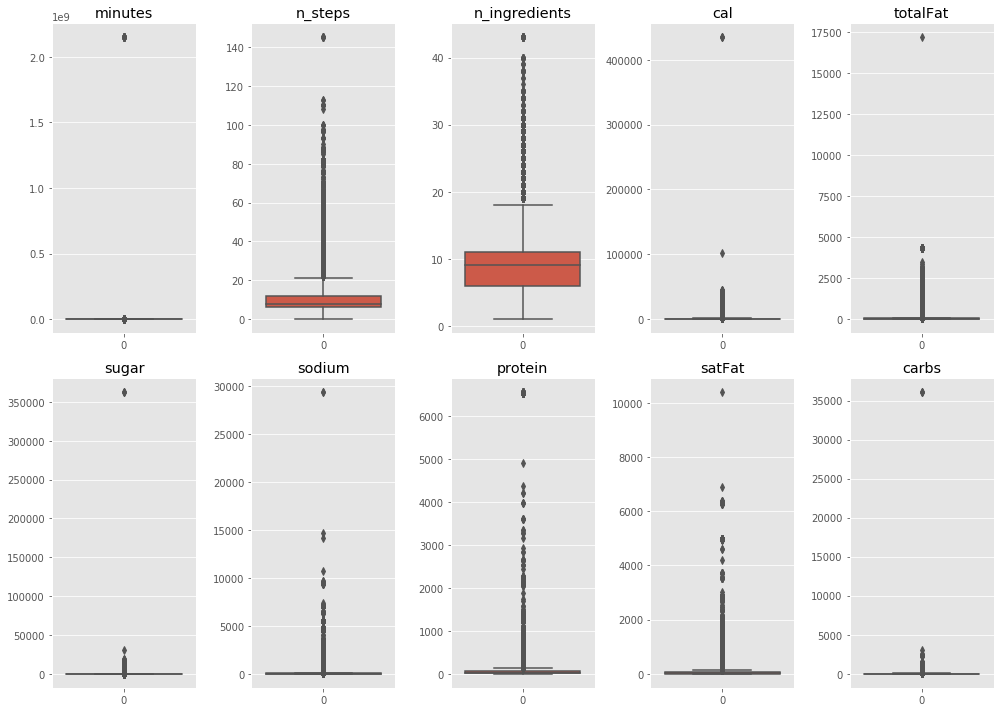

In [17]:
#Get all numeric columns
numeric_columns = ['minutes', 'n_steps', 'n_ingredients', 'cal', 'totalFat', 'sugar', 'sodium', 'protein', 'satFat', 'carbs']

plt.style.use('ggplot')
fig, axis = plt.subplots(2,5,figsize=(14,10))
axis = axis.ravel()
for i,ax in enumerate(axis):
    sns.boxplot(data=Merged_Data2[numeric_columns[i]],ax=ax)
    ax.set(title=numeric_columns[i])
plt.tight_layout()
plt.savefig('boxplots.png')
plt.show()

Removing outliers

To remove the outliers i will set my lower and upper bound as : lower bound = Q1 - 1.5 * IQR upper bound = Q3 + 1.5 * IQR.
Tha values out of these range is considered as outliers and we have to remove them.


In [0]:
# Removing values according to IQR
Columns_Remove_Outliers=['n_steps','minutes','n_ingredients','cal', 'totalFat', 'sugar',   'sodium', 'protein', 'satFat', 'carbs']
for col in Columns_Remove_Outliers:
    IQR = Merged_Data2[col].quantile(0.75) - Merged_Data2[col].quantile(0.25)
    colmax = Merged_Data2[col].quantile(0.75) + 2.5 * IQR
    colmin = Merged_Data2[col].quantile(0.25) - 2.5 * IQR
    Merged_Data2 = Merged_Data2[ (Merged_Data2[col] < colmax) & (Merged_Data2[col] > colmin) ]


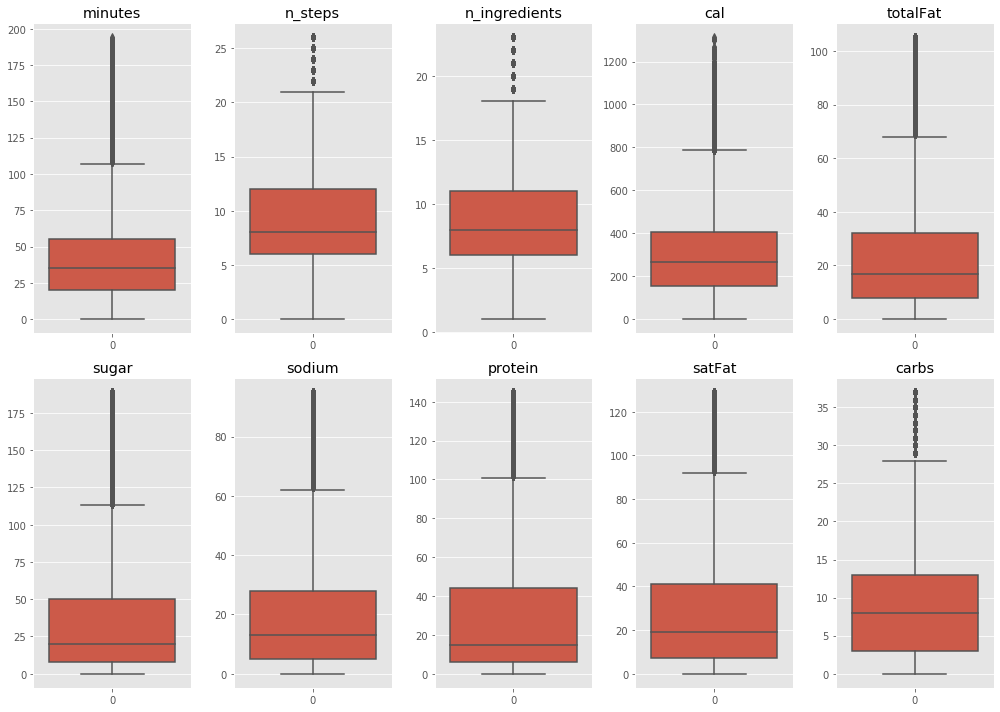

In [19]:
#Now we will look at distributions again
plt.style.use('ggplot')
fig, axis = plt.subplots(2,5,figsize=(14,10))
axis = axis.ravel()
for i,ax in enumerate(axis):
    sns.boxplot(data=Merged_Data2[numeric_columns[i]],ax=ax)
    ax.set(title=numeric_columns[i])
plt.tight_layout()
plt.savefig('boxplots.png')
plt.show()

This is much better than before removing the outliers

Objective of the text analysis task we are trying to do:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


But how to determine if a review is positive or negative?

We could use the Rating column. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In [20]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
Merged_Data2['rating_plus_Minus'] = Merged_Data2['rating'].apply(partition)
Merged_Data2['rating_plus_Minus'].value_counts()



1    808547
0     63342
Name: rating_plus_Minus, dtype: int64

In [21]:
Merged_Data1 = Merged_Data2[Merged_Data2['rating_plus_Minus']==1][1:150000]
Merged_Data0 = Merged_Data2[Merged_Data2['rating_plus_Minus']==0]
Merged_Data2 = Merged_Data1.append(Merged_Data0, ignore_index= True)
Merged_Data2.rating_plus_Minus.value_counts()


1    149999
0     63342
Name: rating_plus_Minus, dtype: int64

# Text Preprocessing

In the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = Merged_Data2['review'].values[1123]
print(sent_0)
print("="*50)

sent_1000 = Merged_Data2['review'].values[1678]
print(sent_1000)
print("="*50)

sent_1500 = Merged_Data2['review'].values[4578]
print(sent_1500)
print("="*50)

sent_4900 = Merged_Data2['review'].values[7890]
print(sent_4900)
print("="*50)


# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)


#Extract text
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup
soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)


#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

# decontract text
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase



In [23]:
#we are creating custom stopword list by removing the words( 'no', 'nor', 'not') from the stop words list

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


#Combining all the above steps into one function

from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(Merged_Data2['review'].values):
    sentence = re.sub(r"http\S+", "",str(sentence))
    sentence = BeautifulSoup(str(sentence), 'lxml').get_text()
    sentence = decontracted(str(sentence))
    sentence = re.sub("\S*\d\S*", "", str(sentence)).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', str(sentence))
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
preprocessed_reviews[1500]

 13%|█▎        | 27990/213341 [00:08<00:56, 3287.14it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 213341/213341 [01:05<00:00, 3266.95it/s]


'really good not big fan flavor banana general used half banana two dollops plain nonfat yogurt make creamy'

In [24]:
preprocessed_reviewsDF = pd.DataFrame(preprocessed_reviews, index= Merged_Data2.index)
Preprocessed_Review_Ratings = preprocessed_reviewsDF.join(Merged_Data2)[['rating_plus_Minus','review']]
Preprocessed_Review_Ratings.head(n=5)

,rating_plus_Minus,review
0,1,This was a nice change. I used butternut squas...
1,1,Excellent recipe! I used butternut squash and ...
2,1,This recipe was wonderful. Instead of using t...
3,1,"We liked this, but the I only baked for 15 min..."
4,1,No leftovers here. As Coleen114 mentioned this...


# Featurization

In [0]:
Y = Preprocessed_Review_Ratings['rating_plus_Minus'].values
X = Preprocessed_Review_Ratings['review'].values


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X.astype('U'), Y, test_size=0.33) # this is random splitting
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(142938,) (142938,)
(70403,) (70403,)


Now we will use different methods to convert the review text to vector

# Bag of words

In [0]:
vectorizer = CountVectorizer()

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.fit_transform(X_train)


In [0]:
X_test_bow = vectorizer.transform(X_test)

In [62]:
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(142937, 49494) (142937,)
(70402, 49494) (70402,)


# Applying KNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
test_auc = []
K = [1]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    neigh.fit(X_train_bow, y_train)
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_test_pred =  neigh.predict_proba(X_test_bow)[:,1]
  
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    test_auc.append(roc_auc_score(y_test, y_test_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, test_auc, label='Test AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

NameError: ignored

# TF-IDF

In [41]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaah', 'aah', 'aahed', 'aahing', 'aahs', 'aaliyah', 'aaliyah aaron', 'aaliyah mum']
the shape of out text TFIDF vectorizer  (1132367, 347565)
the number of unique words including both unigrams and bigrams  347565


# Building Word2Vec Model using our own text corpus
Preparing Reviews for gensim model

In [0]:
# I'm going to train my own Word2Vec model using our processed reviews text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [28]:

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])


number of words that occured minimum 5 times  28907
sample words  ['Yummy!', 'Used', 'leftover', 'rotisserie', 'chicken', 'and', 'regular', 'half', 'half.', "Didn't", 'have', 'reduced', 'sodium', 'broth,', 'the', 'sauce', 'was', 'pretty', 'salty.', 'Quick', 'to', 'fix,', 'even', 'picky', 'kids', 'ate', 'them.', 'Thanks', 'for', 'sharing', 'recipe!', 'Fantastic', 'salad', 'that', 'I', 'will', 'be', 'making', 'often!', 'So', 'simple', 'make', 'dressing', 'has', 'a', 'wonderful', 'orange', 'flavor', 'blends', 'well']


In [29]:
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('bad'))

[('wonderful', 0.9448240399360657), ('fantastic', 0.9179114103317261), ('fabulous', 0.9033703804016113), ('terrific', 0.887316882610321), ('lovely', 0.8498516082763672), ('delicious', 0.8493126034736633), ('good', 0.8090227246284485), ('nice', 0.7968142032623291), ('yummy', 0.7959136366844177), ('perfect', 0.7952252626419067)]
[('obviously', 0.7939737439155579), ('bad,', 0.7675493359565735), ('funny', 0.7180458903312683), ('fair', 0.7030434012413025), ('horrible', 0.6840753555297852), ('bad.', 0.6688066124916077), ('horrible,', 0.6472567915916443), ('ok', 0.6425807476043701), ('terrible', 0.6386770606040955), ('okay', 0.6357966065406799)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# Converting Reviews into Numerical Vectors using W2V vectors

#  Converting Train data Text to Avg W2V

In [30]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)
print(sent_vectors_train.shape)
print(sent_vectors[0])

100%|██████████| 142938/142938 [07:49<00:00, 304.18it/s]


(142938, 50)
[ 0.22859204 -0.12079117  0.22179815  0.04788945  0.26419327 -0.97107598
  0.45566398 -0.56042749  0.71250621 -0.08028022  0.25312386  0.12353143
 -0.20612144 -0.59281396  0.15777176  0.29816166 -0.93094987 -0.43048628
 -0.72338246 -0.25427608 -0.98300902 -0.43861518 -0.86102128  1.09736793
  0.79814784  0.74883595  0.55782019  0.32944006  0.07935022 -0.82278717
  0.47715142 -0.60603553 -0.84196815  0.18285183  0.96287477 -0.69008381
  0.33115835 -0.74318388  0.26043825  0.11517089  0.05639136  0.46105565
  0.47258098 -0.01890247  0.04401512 -0.32761212  0.15039451  0.47029188
 -0.02505721 -0.23756008]


# Converting Test data Text to Avg W2V

In [31]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 70403/70403 [03:41<00:00, 318.46it/s]


(70403, 50)
[ 0.06297215 -0.14192812  0.3836453  -0.55301831  0.40639271 -1.53408594
  0.35516252  0.02975723  0.2449142   0.15138074  1.30457036 -0.65565635
  0.51124815 -0.36111175  0.45730648 -0.12929303 -0.70568492 -0.20468715
 -0.65196246  0.7446377  -0.30352508 -0.37555625 -0.09464471  0.66679685
  1.56915558 -0.70198115 -0.98964007  0.39259458 -0.68566521 -0.4410602
  0.48603958  0.25396468 -0.03244009 -1.53565942  1.21982544 -1.66362152
  0.30117046  0.53575364 -0.13249347  0.1809834   0.59287867 -0.50167001
  0.38422367  0.41541638 -0.19179391 -0.24636281 -0.31776545  0.81752866
  0.02406063 -1.14643323]


# Prediction using KNN(Avg W2V)

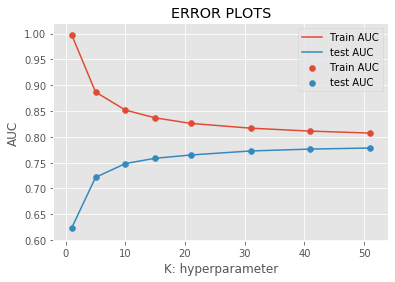

In [37]:
train_auc = []
test_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs = -1)
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_test_pred =  neigh.predict_proba(sent_vectors_test)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    test_auc.append(roc_auc_score(y_test, y_test_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, test_auc, label='test AUC')
plt.scatter(K, test_auc, label='test AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))

Train confusion matrix
[[13341 29086]
 [ 3186 97325]]
Test confusion matrix
[[ 6389 14526]
 [ 1768 47720]]


# TFIDF weighted W2v


In [0]:
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


 22%|██▏       | 31397/142938 [23:46<1:07:04, 27.71it/s]

# Prediction using KNN (TF-IDF Weighted W2V)

In [0]:
train_auc = []
test_auc = []
K = [1, 21,41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs = -1)
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_test_pred =  neigh.predict_proba(sent_vectors_test)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    test_auc.append(roc_auc_score(y_test, y_test_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, test_auc, label='test AUC')
plt.scatter(K, test_auc, label='test AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))